In [1]:
from scipy.stats import kendalltau
import numpy as np
import xarray as xa
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
import arviz as az
from wisdom.data import load_responses
from wisdom.statistics import mode

In [2]:
sns.set_context("talk")
sns.set_palette("Spectral_r")

In [3]:
woc = load_responses("../data/")
woc = woc[woc.index.get_level_values(1) != "Overall.hazardous"]
woc_stacked = woc.stack().reset_index()
cat_hazard = woc_stacked["hazard"].astype("category").cat.categories
cat_expert = woc_stacked["expert"].astype("category").cat.categories

inference = xa.open_dataset("../outputs/model_inference_anon.nc")

# Experts agreement scores

Agreement scores correlation KendalltauResult(correlation=0.13235294117647056, pvalue=0.4896069682169023)


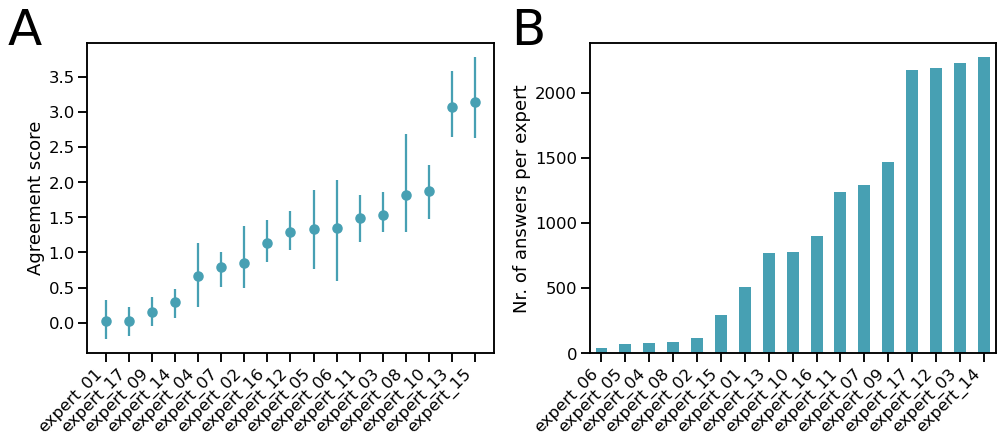

In [7]:
fig2AB, axes = plt.subplots(1, 2, figsize=(14, 6))
ax = axes.ravel()

# Expert agreement scores
expert_scores = inference.posterior_expert_scores.to_pandas().T.stack().reset_index()
modes = expert_scores.groupby("expert").apply(lambda g: mode(g[0].values))
hdi = az.hdi(inference.posterior_expert_scores.to_numpy()[None, ...], hdi_prob=0.95)

ax[0].vlines(x=range(len(cat_expert)), ymin=hdi[modes.argsort(), 0], ymax=hdi[modes.argsort(), 1])
ax[0].scatter(x=range(len(cat_expert)), y=modes.sort_values())
ax[0].set_xticks(ticks=range(len(cat_expert)))
ax[0].set_xticklabels(labels=modes.sort_values().index, rotation=45, ha="right")
ax[0].set_ylabel("Agreement score")

df = (~woc.isna()).sum().sort_values()
df.plot(kind="bar", ax=ax[1])
ax[1].set_xticklabels(df.index, rotation=45, ha='right')  # Adjust the rotation angle and alignment as needed
ax[1].set_xlabel("")
ax[1].set_ylabel("Nr. of answers per expert")

print("Agreement scores correlation", kendalltau(modes, df))
fig2AB.text(0, 0.95, 'A', fontsize=50, transform=fig2AB.transFigure)
fig2AB.text(0.5, 0.95, 'B', fontsize=50, transform=fig2AB.transFigure)
fig2AB.tight_layout()

# Endpoint difficulty scores

Difficulty scores correlation KendalltauResult(correlation=-0.02941176470588235, pvalue=0.9031966906069087)


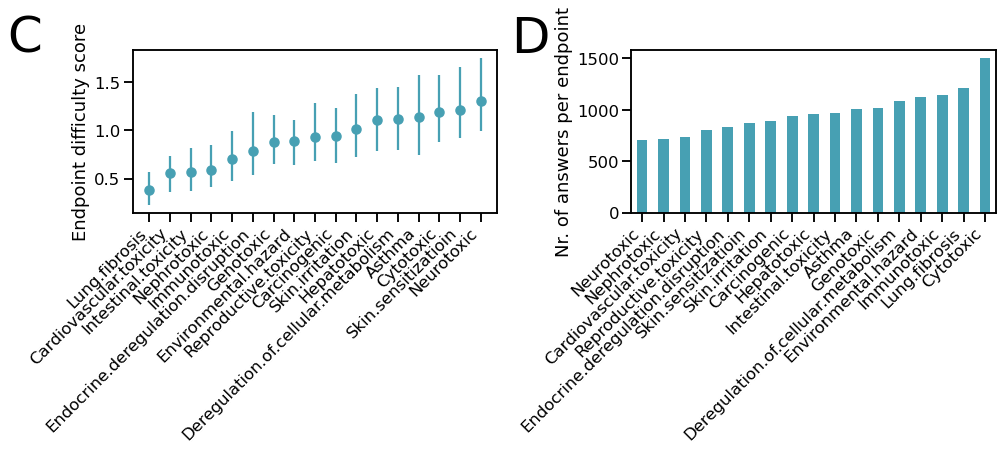

In [12]:
fig2CD, axes = plt.subplots(1, 2, figsize=(14, 6))
ax = axes.ravel()
difficulty_scores = inference.posterior_difficulty_score.to_pandas().T.stack().reset_index()
modes = np.exp(difficulty_scores.groupby("hazard").apply(lambda g: mode(g[0].values)))
hdi = az.hdi(np.exp(inference.posterior_difficulty_score.to_numpy()[None, ...]), hdi_prob=0.95)
ax[0].vlines(x=range(len(cat_hazard)), ymin=hdi[modes.argsort(), 0], ymax=hdi[modes.argsort(), 1])
ax[0].scatter(x=range(len(cat_hazard)), y=modes.sort_values())
ax[0].set_xticks(ticks=range(len(cat_hazard)))
ax[0].set_xticklabels(labels=modes.sort_values().index, rotation=45, ha="right")
ax[0].set_ylabel("Endpoint difficulty score")

df = woc.stack().reset_index().groupby("hazard").size().sort_values()
df.plot(kind="bar", ax=ax[1])
ax[1].set_xticklabels(df.index, rotation=45, ha='right')  # Adjust the rotation angle and alignment as needed
ax[1].set_xlabel("")
ax[1].set_ylabel("Nr. of answers per endpoint")

print("Difficulty scores correlation", kendalltau(modes, df))
fig2CD.text(0, 0.95, 'C', fontsize=50, transform=fig2CD.transFigure)
fig2CD.text(0.5, 0.95, 'D', fontsize=50, transform=fig2CD.transFigure)
fig2CD.tight_layout()